<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA
</center></font>


<center><h2>Proyecto 1</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: _______</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>


In [ ]:
from IPython.display import IFrame, display
filepath = "Proyecto_1_EIE401.pdf"
IFrame(filepath, width=700, height=400)

Debes usar el sitio https://gwosc.org/eventapi/html/GWTC/, donde encuentras todo el catálogo de observaciones con los datos en diferentes formatos. Debes seleccionar una detección para tu estudio y descargar los datos correspondientes (H5 o TXT), lo que posteriormente deberás tratar de manera digital como audio (serie de tiempo).
tip: Te recomiendo tomar la serie de tiempo corta (32 segundos) para facilitar el análisis, y asegurarte de tomar la tasa de muestreo más alta.
tip: Asegúrate de tomar un caso cuyo espectrograma de muestra, indique una señal clara y fuerte para facilitar tu trabajo, de otra forma es posible que no logres aislarla lo suficiente.


## 1. Carga de Datos


En la siguiente sección se cargan los datos a utilizar del archivo "H-H1_GWOSC_16KHZ_R1-1268903496-32.txt"

524288

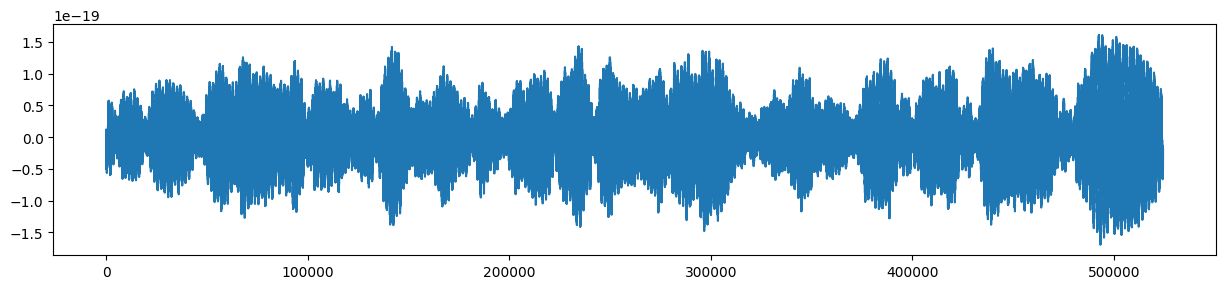

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio


# cargar datos

archivo = pd.read_csv("H-H1_GWOSC_16KHZ_R1-1268903496-32.txt.gz", skiprows=3, header=None)

signal = archivo.iloc[:, 0]

plt.figure(figsize=(15,3))
plt.plot(signal)

len(signal)

## 2. Convertir en audio
Es una forma de validar que tenemos un alto componente de ruido en la señal y que el interés es eliminarlo para encontrar una señal candidata.

Te recomiendo hacer una señal de audio de cada uno de las etapas para así validar como va el proceso. Al final deberás obtener un señal con CHIRP o BUMP. Son sonidos que comprueban que tienes una cantidad de potencia que sobre destaca sobre el ruido.

In [3]:
#Se convierte en audio y se guarda

from scipy.io import wavfile
import numpy as np


# Frecuencia de muestreo
sample_rate = 16000

# Se normalizan los datos
signal1 = np.asarray(signal)
data_normalized = np.int16(signal1 / np.max(np.abs(signal1)) * 32767)

# Se guarda el audio como "audio.wav"
wavfile.write('audio.wav', sample_rate, data_normalized)

display(Audio(data=data_normalized, rate=sample_rate))


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


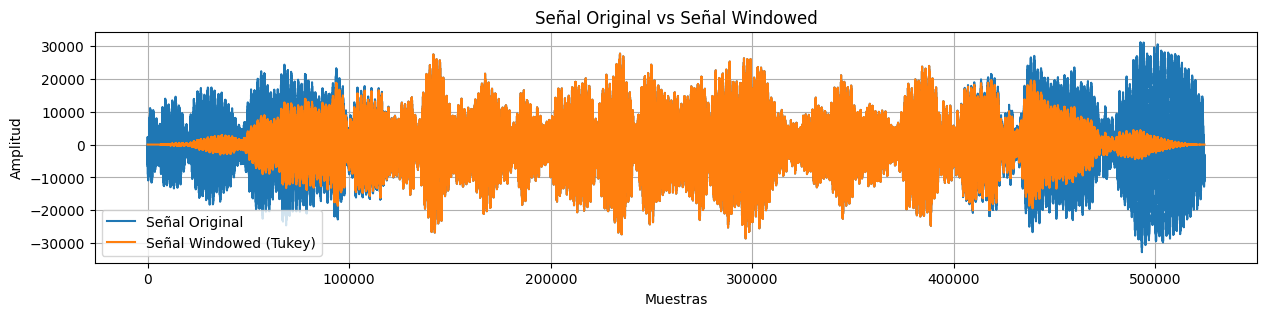

In [5]:
import scipy.signal as signal

# Se carga el audio
sample_rate, data = wavfile.read('audio.wav')

# Se utiliza la ventana Blackman
window = signal.windows.tukey(len(data), 0.5)

# Se aplica la ventana a la señal
data_windowed = data * window

# Se grafica la señal original y la señal windowed
plt.figure(figsize=(15, 3))
plt.plot(data, label='Señal Original')
plt.plot(data_windowed, label='Señal Windowed (Tukey)')
plt.title('Señal Original vs Señal Windowed')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
# plt.xlim(0,50000)
plt.legend()
plt.grid(True)
plt.show()

display(Audio(data=data_windowed, rate=sample_rate))

## 3. Análisis de Fourier
Al realizar la conversión, queremos ver cuales son las componentes de ruido que más afectan al instrumento y debemos ignorar en el análisis. Eso se ve como "pico" o la apariencia de "peine".
Se debe presenta la densidad espectral de potencia antes y después de la función de Windowing.


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile


# Se calcula la Transformada de Fourier de las señales
fft_data = np.fft.fft(data)
fft_windowed = np.fft.fft(data_windowed)

# Se busca la frecuencia de las fft
frequencies = np.fft.fftfreq(len(data), 1/sample_rate)

# Se calcula la densidad de potencia espectral en ambos casos
psd = np.abs(fft_data)**2
psd_windowed = np.abs(fft_windowed)**2

# Se normalizan ambas PSD
psd_normalized = psd / (sample_rate * len(data))
psd_wn = psd_windowed / (sample_rate * len(data))





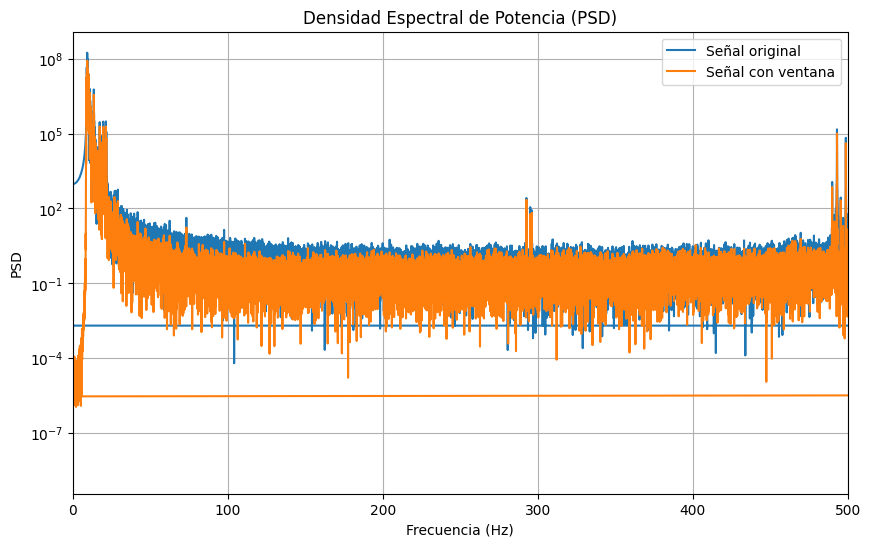

In [17]:
# Se grafican las PSD con y sin ventana
plt.figure(2,figsize=(10, 6))
plt.semilogy(frequencies, psd_normalized,label='Señal original')
plt.semilogy(frequencies, psd_wn, label='Señal con ventana')
plt.title('Densidad Espectral de Potencia (PSD)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD')
plt.xlim(0,500)
plt.grid(True)
plt.legend()
plt.show()

## 4. Procesamiento
Debes inferir de tu estudio, cual es el proceso que aplican a la señal y reproducirlo. Es posible que cada estudiante llegue a una solución más o menos diferente, pues no hay un código abierto donde esté el procedimiento completo.


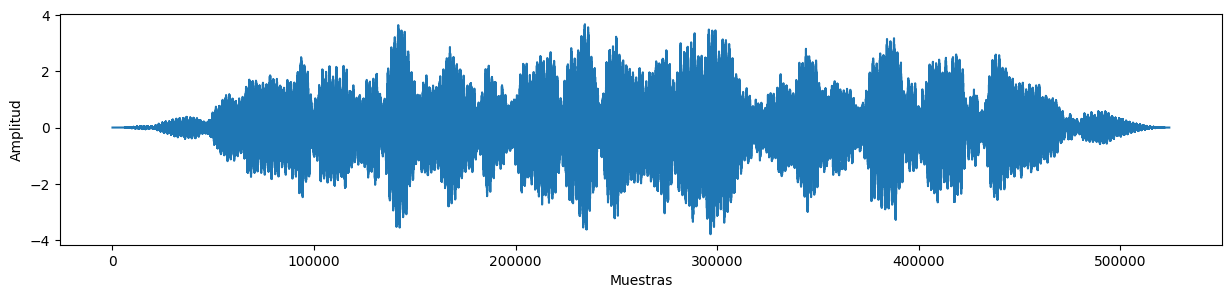

In [25]:
#Blanqueamiento de señal

#Se dividen los coeficientes de Fourier por la densidad espectral de amplitud estimada del ruido
whitened_audio_fourier = fft_windowed / np.sqrt(np.mean(psd_windowed))

#Se calcula la IFFT para obtener la señal blanqueada en el dominio temporal
whitened_audio = np.fft.ifft(whitened_audio_fourier).real

#Se normaliza la señal resultante para que tenga una varianza de 1
whitened_audio /= np.std(whitened_audio)

plt.figure(figsize=(15,3))
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.plot(whitened_audio)

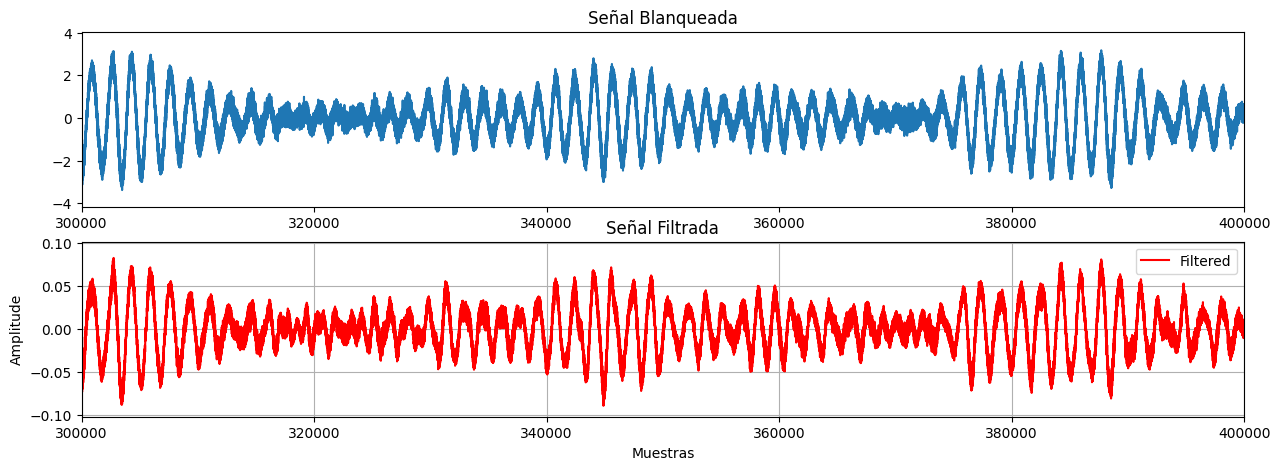

In [27]:
from scipy.fft import fft, ifft
from scipy.signal import butter, filtfilt
import scipy.signal as signal

#Se definen las características del filtro
f_low = 50  # Frecuencia de corte menor
f_high = 270  # Frecuencia de corte mayor
order = 1  # Orden del filtro
nyquist = 0.5 * sample_rate #Frecuencia sampleo de Nyquist
low = f_low / nyquist #Inferior de nyquist según deseada
high = f_high / nyquist #Superior de nyquist según deseada

#Se usa un filtro Butterwort pasabandas
b, a = signal.butter(order, [low, high], btype='band')
filtered_audio = signal.filtfilt(b, a, whitened_audio)

# Se grafica la señal blanqueada y la filtrada
plt.figure(figsize=(15, 5))
plt.subplot(211)
plt.title('Señal Blanqueada')
plt.plot(whitened_audio, label='Original')
plt.xlim(300000, 400000)
plt.subplot(212)
plt.title('Señal Filtrada')
plt.plot(filtered_audio,'r', label='Filtered')
plt.xlabel('Muestras')
plt.ylabel('Amplitude')
plt.xlim(300000, 400000)
plt.legend()
plt.grid(True)
plt.show()


display(Audio(data=filtered_audio, rate=sample_rate))

# Resampling
Para lograr una mejor definición de la señal, se debe hacer un resampleo. Esto tienen consecuencias por eso debe elegirse bien la frecuencia de tal forma que no se introduzca ruido.

In [20]:
import scipy.signal as sps

#Se define la nueva tasa de muestreo
new_sample_rate = 32000

amplitudes = np.array(filtered_audio)

#Se normaliza
amplitudes = 0.9*amplitudes/max(abs(amplitudes));

#Se realiza el upsampling
number_of_samples = round(len(filtered_audio) * float(new_sample_rate) / sample_rate)
print(number_of_samples)
data_resampled = sps.resample(filtered_audio, number_of_samples)

#Se guarda el archivo de audio resampleado
wavfile.write('audio_resampled.wav', new_sample_rate, data_resampled)

1048576


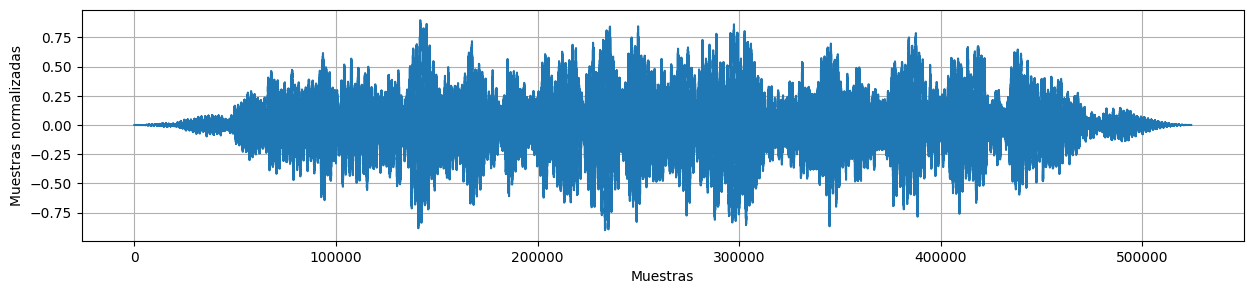

In [21]:
#Grafica
plt.figure(figsize=(15,3))
plt.plot(amplitudes)
plt.xlabel('Muestras')
plt.ylabel('Muestras normalizadas')
#plt.xlim(0,5000000)
plt.grid()

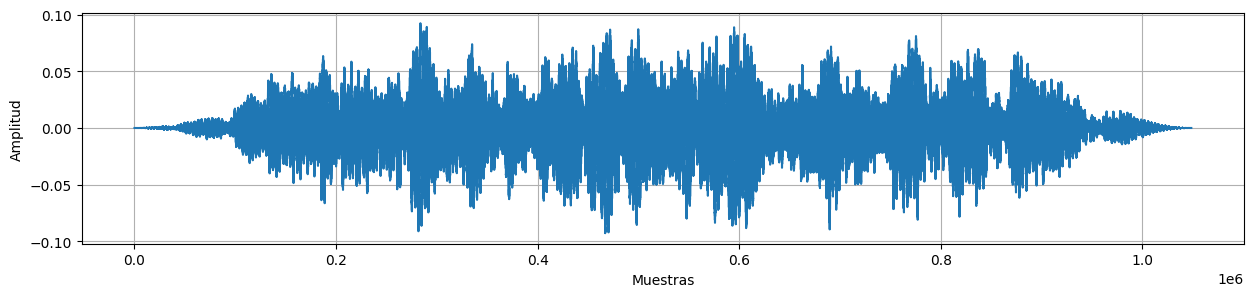

In [24]:
# Graficar la señal resampleada
plt.figure(figsize=(15,3))
plt.plot(data_resampled)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid()
Audio(data_resampled, rate=32000)